In [1]:
# Import needed libraries.
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from impc_api import batch_solr_request, solr_request

In [2]:
def fetch_children(mp_id):
    num_found, df = solr_request(
        core='mp',
        params={
            'q': f'mp_id:"{mp_id}"',
            'fl': 'child_mp_id',
            'rows': 100
        },
        silent=True
    )

    if num_found == 0 or 'child_mp_id' not in df.columns:
        return []

    if num_found > 100:
        raise ValueError(f"Too many results found: {num_found}. Aborting.")

    df = df.explode('child_mp_id').dropna(subset=['child_mp_id'])
    return df['child_mp_id'].unique().tolist()

def fetch_all_descendants(mp_id):
    visited = set()
    queue = [mp_id]
    all_terms = [mp_id]

    while queue:
        current = queue.pop(0)
        if current in visited:
            continue
        visited.add(current)

        children = fetch_children(current)
        new_terms = [child for child in children if child not in visited]

        all_terms.extend(new_terms)
        queue.extend(new_terms)

    return all_terms

def filter_impc_mp_ids(mp_ids):
    valid_terms = []

    for mp_id in mp_ids:
        # Check MP core.
        num_found_mp, df_mp = solr_request(
            core='mp',
            params={
                'q': f'mp_id:"{mp_id}"',
                'fl': 'mp_id, mp_term',
                'rows': 100
            },
            silent=True
        )

        if num_found_mp == 1:
            # Check statistical results core.
            num_found_stat, _ = solr_request(
                core='statistical-result',
                params={
                    'q': f'mp_term_id_options:"{mp_id}"',
                    'fl': 'mp_term_id_options',
                    'rows': 1
                },
                silent=True
            )
            if num_found_stat > 0:
                valid_terms.append(mp_id)

    return valid_terms

def fetch_statistical_data(mp_id, fields):
    all_descendants = fetch_all_descendants(mp_id)
    mp_term_list = filter_impc_mp_ids(all_descendants)

    query = " OR ".join(f'mp_term_id_options:"{term}"' for term in mp_term_list)
    params = {
        'q': query,
        'fl': fields
    }

    return batch_solr_request(core='statistical-result', params=params, download=False)


def summarise_colony_significance(df, term_name):
    if df is None or df.empty:
        print(f"- {term_name.upper()}: No data found.\n")
        return

    df = df.drop(columns=['parameter_stable_id'], errors='ignore')

    # Convert lists to strings.
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():
            df[col] = df[col].apply(str)

    df = df.drop_duplicates()

    # Save deduplicated data.
    output_dir = Path("output")
    output_dir.mkdir(exist_ok=True)

    filename = f"{term_name.lower().replace(' ', '_')}_deduplicated.csv"
    filepath = output_dir / filename
    df.to_csv(filepath, index=False)
    print(f"Saved deduplicated data to: {filepath}")

    # Calculate significance.
    grouped = df.groupby(
        ['colony_id', 'allele_symbol']
    )['significant']

    summary = grouped.any().reset_index()

    count_true = summary['significant'].sum()
    count_false = len(summary) - count_true

    print(f"- {term_name.upper()}")
    print(f"Significant lines: {count_true}")
    print(f"Non-significant lines: {count_false}")
    print(f"Total lines: {count_true + count_false}\n")

requested_fields = [
    'allele_symbol',
    'colony_id',
    'marker_symbol',
    'mp_term_id_options',
    'parameter_stable_id',
    'pipeline_stable_id',
    'significant'
]
requested_fields = ','.join(requested_fields)

## Number of lines assessed for otic vesicle morphology

In [3]:
df = fetch_statistical_data("MP:0009806", requested_fields)
summarise_colony_significance(df, "Otic vesicle morphology")

Number of found documents: 1116


5000it [00:00, 11147.90it/s]                                  

Saved deduplicated data to: output/otic_vesicle_morphology_deduplicated.csv
- OTIC VESICLE MORPHOLOGY
Significant lines: 7
Non-significant lines: 812
Total lines: 819



## Number of lines assessed for ABR

In [4]:
df = fetch_statistical_data('MP:0004738', requested_fields)
summarise_colony_significance(df, "Auditory brainstem response")

Number of found documents: 43941


45000it [00:04, 9618.07it/s]                                  

Saved deduplicated data to: output/auditory_brainstem_response_deduplicated.csv
- AUDITORY BRAINSTEM RESPONSE
Significant lines: 335
Non-significant lines: 6784
Total lines: 7119



## Number of lines examined for retinal abnormalities

In [5]:
df = fetch_statistical_data('MP:0001325', requested_fields)
summarise_colony_significance(df, "Abnormal retinal phenotype")

Number of found documents: 54872


55000it [00:02, 18638.70it/s]                                 

Saved deduplicated data to: output/abnormal_retinal_phenotype_deduplicated.csv
- ABNORMAL RETINAL PHENOTYPE
Significant lines: 811
Non-significant lines: 8018
Total lines: 8829



## Analyse intersection of ABR (auditory brainstem response) and GEL (otic vesicle morphology) lines / colony_ids

In [6]:
def analyse_df(df, name):
    print(f"\n{name} - Original shape: {df.shape}")
    
    # Drop columns and reset index.
    df_dropped = df.drop(columns=['mp_term_id_options', 'significant', 'pipeline_stable_id']).reset_index(drop=True)
    print(f"{name} - After dropping columns: {df_dropped.shape}")
    
    # Normalise strings (fix the deprecated applymap).
    df_normalised = df_dropped.astype(str).map(lambda x: x.strip() if isinstance(x, str) else x)
    
    # Check for duplicates before removing them.
    duplicates = df_normalised.duplicated()
    
    # Remove duplicates.
    df_unique = df_normalised.drop_duplicates()
    print(f"{name} - After removing duplicates: {df_unique.shape}")
    
    # Count unique colony_ids.
    unique_colony_ids = df_unique['colony_id'].nunique()
    unique_rows = df_unique.shape[0]
    
    print(f"{name} - Unique colony_id values: {unique_colony_ids}")
    print(f"{name} - Unique rows: {unique_rows}")
    
    # Debug: Show cases where colony_id appears multiple times.
    colony_counts = df_unique['colony_id'].value_counts()
    multiple_entries = colony_counts[colony_counts > 1]
    if len(multiple_entries) > 0:
        print(f"{name} - Colony IDs appearing multiple times:")
        for colony_id, count in multiple_entries.head(10).items():
            print(f"  {colony_id}: {count} times")
            # Show the actual rows
            matching_rows = df_unique[df_unique['colony_id'] == colony_id]
            print(f"    Rows: {matching_rows.to_string()}")
    return df_unique.drop(columns=["allele_symbol", "marker_symbol"]).reset_index(drop=True)


ABR Data - Original shape: (7469, 6)
ABR Data - After dropping columns: (7469, 3)
ABR Data - After removing duplicates: (7119, 3)
ABR Data - Unique colony_id values: 7119
ABR Data - Unique rows: 7119

GEL Data - Original shape: (825, 6)
GEL Data - After dropping columns: (825, 3)
GEL Data - After removing duplicates: (819, 3)
GEL Data - Unique colony_id values: 819
GEL Data - Unique rows: 819

ABR unique lines: 7119
GEL unique lines: 819
Intersection (both): 575
ABR only: 6544
GEL only: 244
Venn diagram saved to: output/abr_gel_venn_diagram.png


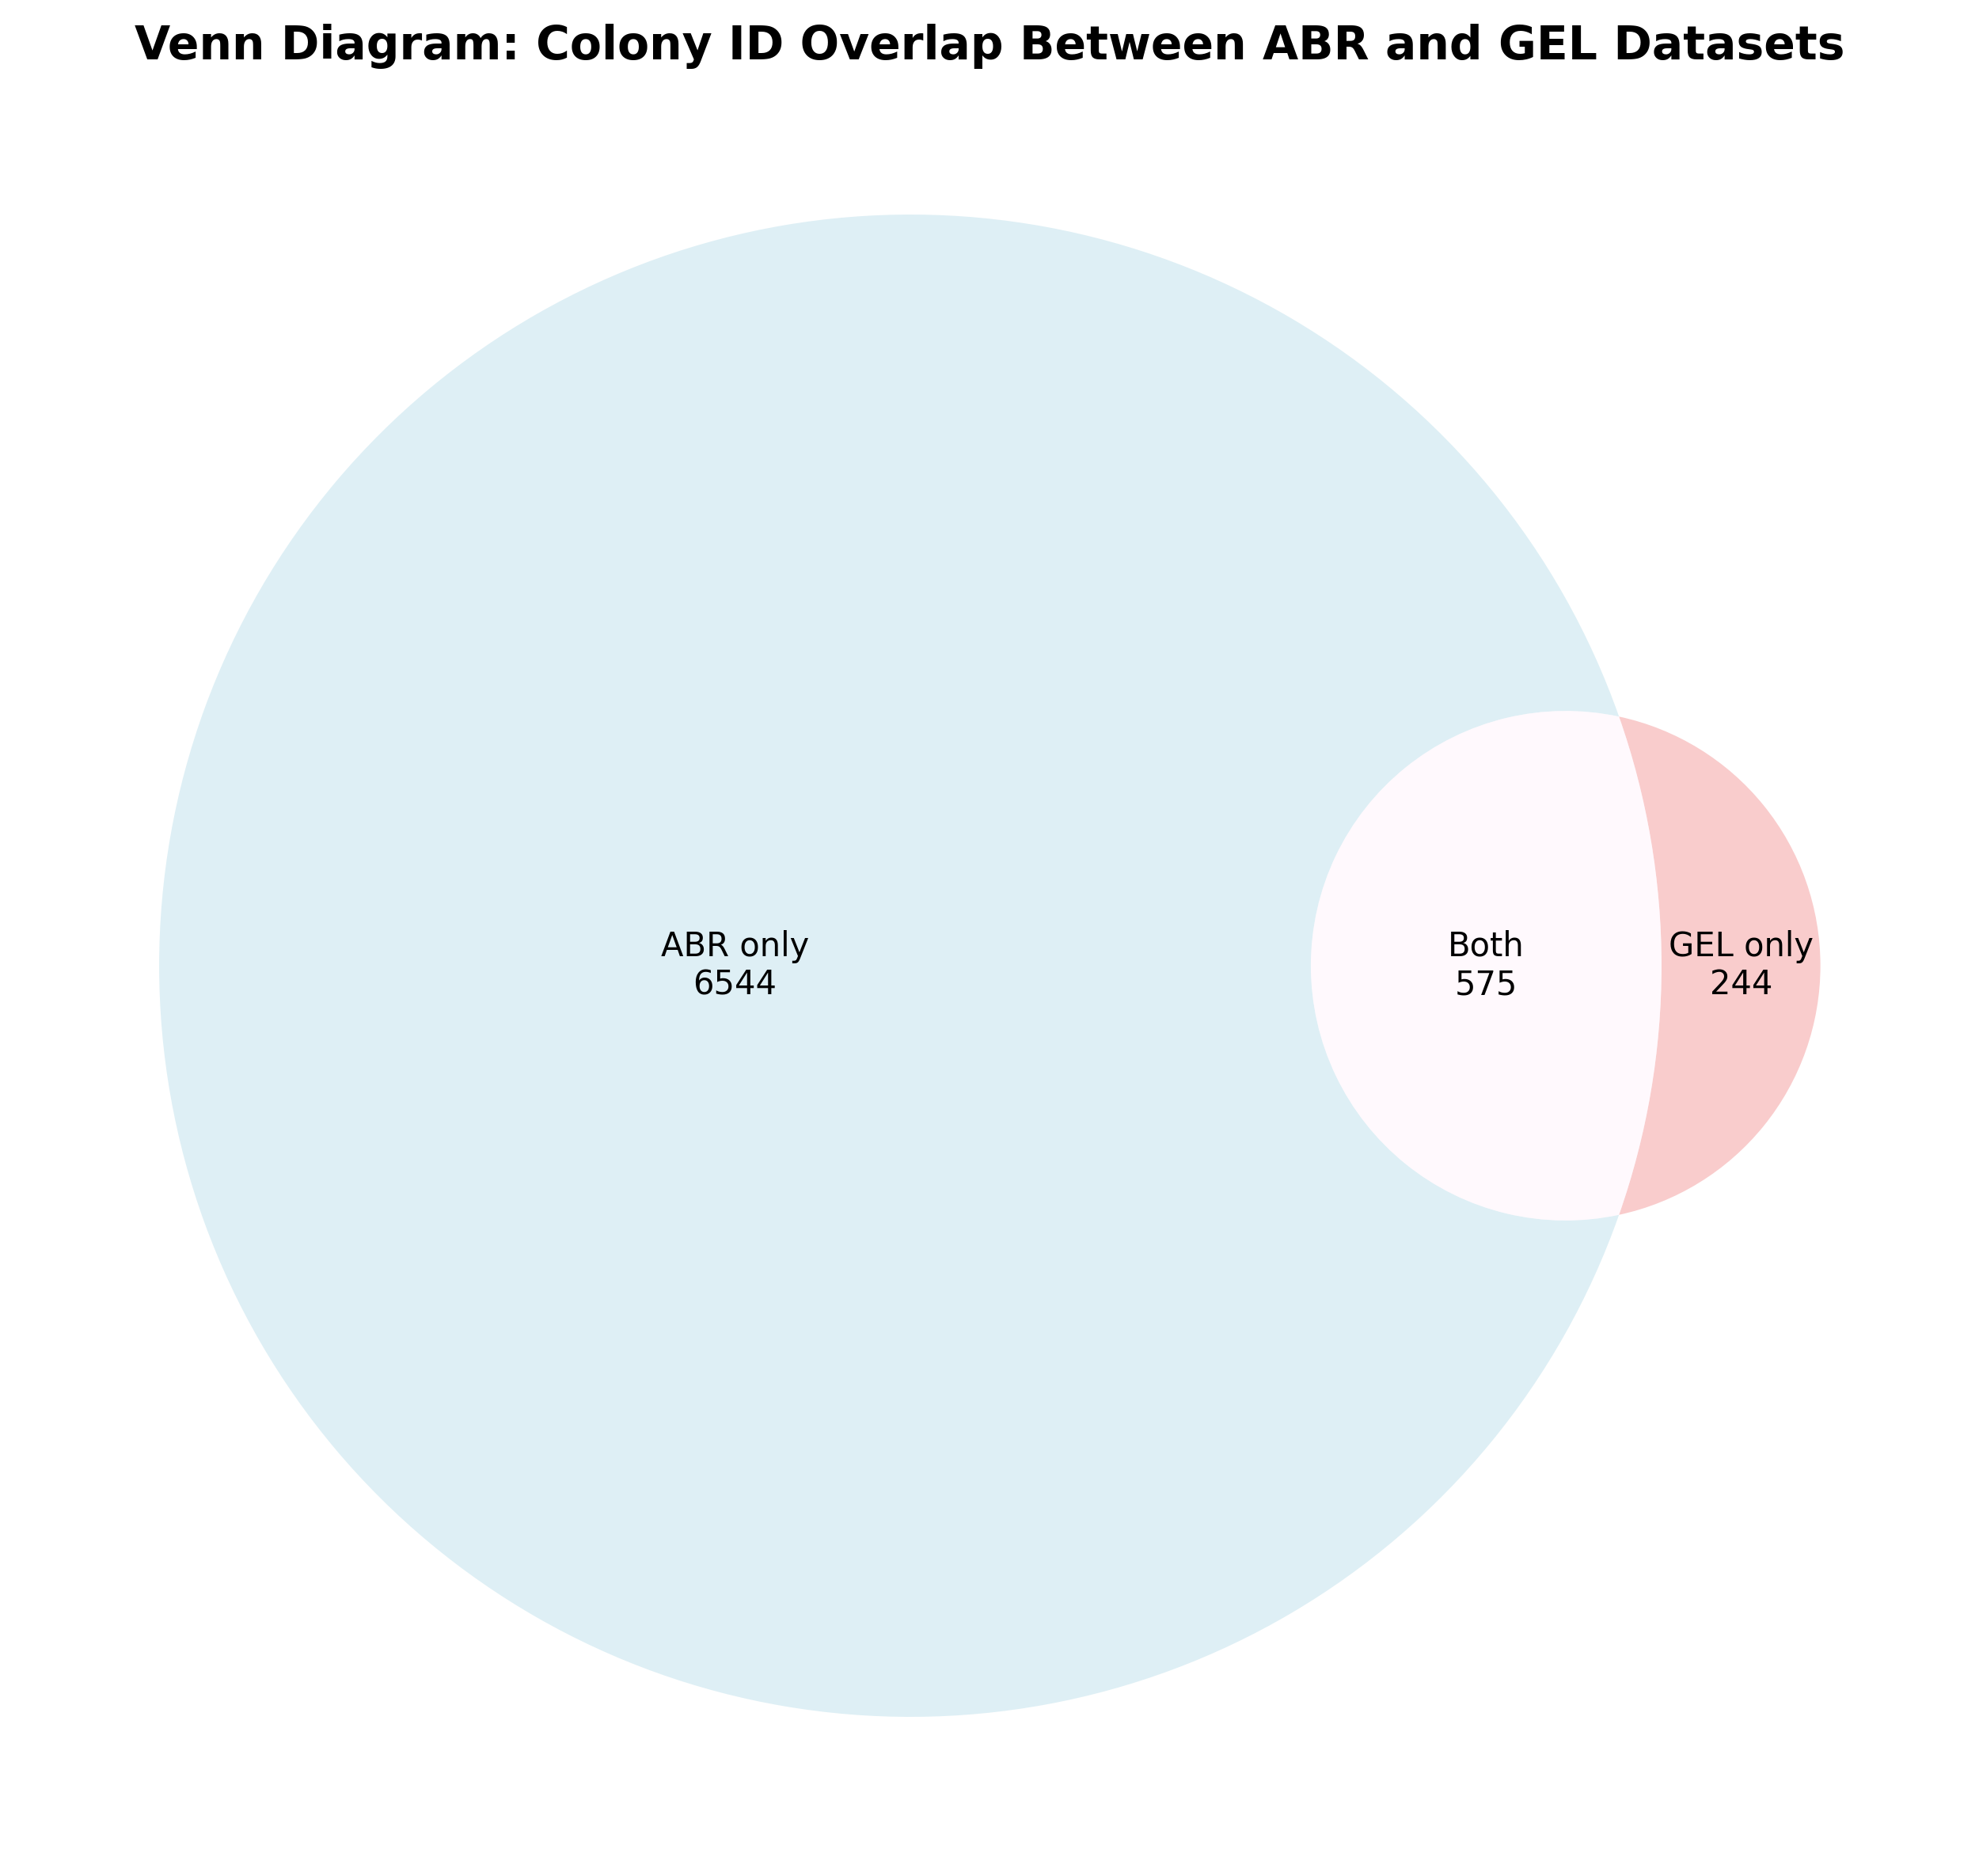

({'H-TH-DEL621-EM1-B6N',
  'HMGU_Tle1_Crispr2_AABO',
  'JR33082',
  'TCPR0946_ADPY',
  'H-CNTNAP2-INS1-EM1-B6N',
  'CR1056',
  'mirKO_ES_PuDtk_5D1-1',
  'CR10458',
  'CCP-Nwd2-EXDEL-EM1-B6N',
  'BL3211',
  'JR33300',
  'H-COL4A3-B07-TM1B',
  'UCD-13532A-D11-1-1',
  'H-Igfbp3-A08-TM1B',
  'JR37639',
  'BL4335',
  'TCPA0563Cre',
  'MUFX',
  'JR24232',
  'JR34436',
  'JR34119',
  'CR11389',
  'MDGW',
  'BL2067',
  'H-Klf14-Del5-EM1-B6N',
  'MUCX',
  'HMGU_Adam30_Crispr1_AAFF-1',
  'MUEV',
  'PMBQ',
  'CR10703',
  'CR10432',
  'JR33311',
  'IP00005555a',
  'MDWN',
  'JR18616',
  'CR10057',
  'TCPA0706Cre',
  'CCP-Fnip1-multiexdel-EM1-B6N',
  'JR32571',
  'BL5536',
  'CCP-Fam45a-exdel-EM1-B6N',
  'JR25582',
  'CCP-Gfi1b-inexdel-EM1-B6N_PH',
  'MUDX',
  'AFFM',
  'CR10712',
  'IP00006384a',
  'JR27474',
  'CCP-Kcnn4-inexdel-EM1-B6N',
  'Herc6_HEPD0664_7_A09-1',
  'CR839',
  'CR10885',
  'H-TBKBP1-A04-TM1B',
  'CCP-Vegfd-exdel-EM1-B6N',
  'BL4306',
  'JR33274',
  'CR10504',
  'BL5549',
  'JR3

In [7]:
def write_set_to_file(set_to_write, filename):
    with open(filename, "w") as f:
        for item in set_to_write:
            f.write(f"{item}\n")

def compare_and_plot_venn(df_init1, df_init2, name1, name2, output_file=None):
    """
    Compare two DataFrames by their 'colony_id' column and plot a Venn diagram.

    Args:
        df_init1 (pd.DataFrame): First dataframe.
        df_init2 (pd.DataFrame): Second dataframe.
        name1 (str): Label for the first dataset (e.g., 'ABR').
        name2 (str): Label for the second dataset (e.g., 'GEL').
        output_file (str, optional): File path to save the figure (e.g., 'output.png').
    """
    df1 = analyse_df(df_init1, f"{name1} Data")
    df2 = analyse_df(df_init2, f"{name2} Data")

    # Get unique colony_id values from each dataframe
    markers1 = set(df1['colony_id'].unique())
    markers2 = set(df2['colony_id'].unique())

    # Calculate intersections and differences
    intersection = markers1 & markers2
    only1 = markers1 - markers2
    only2 = markers2 - markers1

    # Print statistics
    print(f"\n{name1} unique lines: {len(markers1)}")
    print(f"{name2} unique lines: {len(markers2)}")
    print(f"Intersection (both): {len(intersection)}")
    print(f"{name1} only: {len(only1)}")
    print(f"{name2} only: {len(only2)}")

    # Create Venn diagram
    plt.figure(figsize=(12, 8), dpi=300)
    venn = venn2([markers1, markers2], 
                 set_labels=('', ''),
                 set_colors=('lightblue', 'lightcoral'))

    # Add counts to the diagram
    if venn.get_label_by_id('10'):
        venn.get_label_by_id('10').set_text(f'{name1} only\n{len(only1)}')
    if venn.get_label_by_id('01'):
        venn.get_label_by_id('01').set_text(f'{name2} only\n{len(only2)}')
    if venn.get_label_by_id('11'):
        venn.get_label_by_id('11').set_text(f'Both\n{len(intersection)}')

    # Title and layout
    plt.title(f"Venn Diagram: Colony ID Overlap Between {name1} and {name2} Datasets", fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Save to file if specified
    if output_file:
        plt.savefig(output_file)
        print(f"Venn diagram saved to: {output_file}")

    plt.show()
    return only1, intersection, only2

abr_filename = "output/auditory_brainstem_response_deduplicated.csv"
gel_filename = "output/otic_vesicle_morphology_deduplicated.csv"
abr_df = pd.read_csv(abr_filename)
gel_df = pd.read_csv(gel_filename)

compare_and_plot_venn(
    abr_df, 
    gel_df, 
    name1="ABR", 
    name2="GEL", 
    output_file="output/abr_gel_venn_diagram.png"
)


Hearing Data - Original shape: (8294, 6)
Hearing Data - After dropping columns: (8294, 3)
Hearing Data - After removing duplicates: (7363, 3)
Hearing Data - Unique colony_id values: 7363
Hearing Data - Unique rows: 7363

Retina Data - Original shape: (32797, 6)
Retina Data - After dropping columns: (32797, 3)
Retina Data - After removing duplicates: (8829, 3)
Retina Data - Unique colony_id values: 8829
Retina Data - Unique rows: 8829

Hearing unique lines: 7363
Retina unique lines: 8829
Intersection (both): 7053
Hearing only: 310
Retina only: 1776
Venn diagram saved to: output/hearing_retina_venn_diagram.png


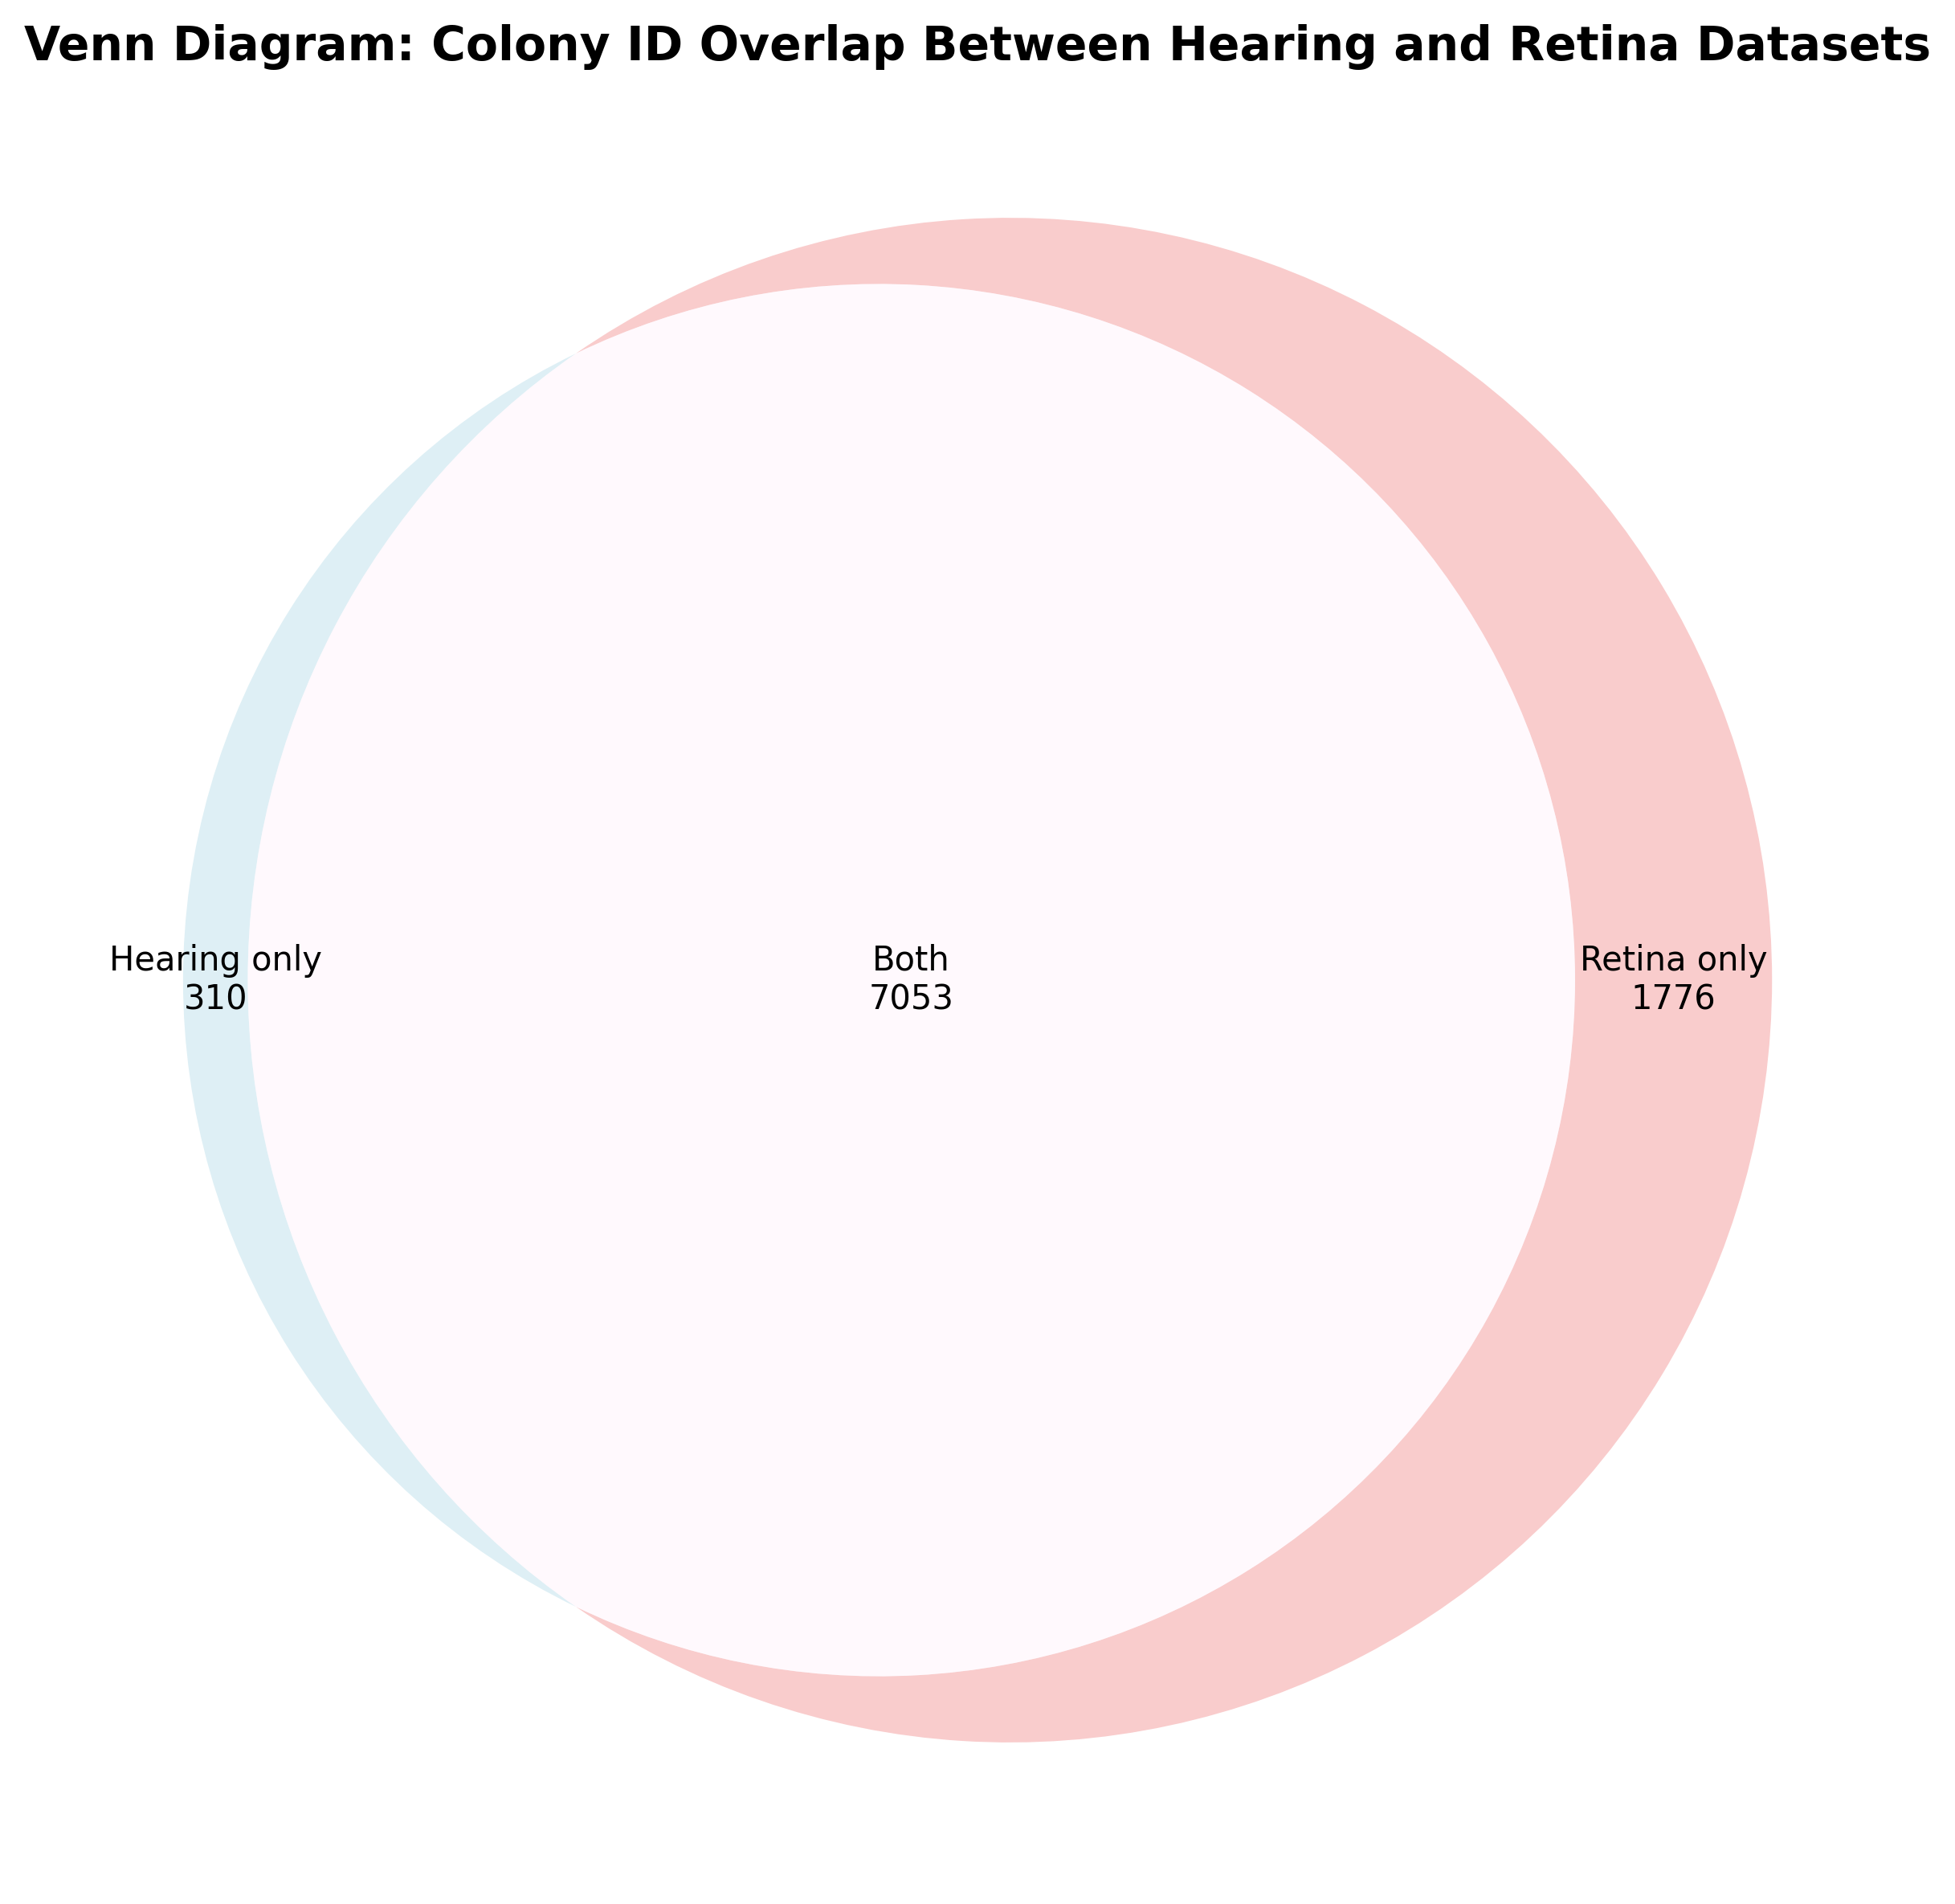

In [8]:
abr_filename = "output/auditory_brainstem_response_deduplicated.csv"
gel_filename = "output/otic_vesicle_morphology_deduplicated.csv"
eye_filename = "output/abnormal_retinal_phenotype_deduplicated.csv"
abr_df = pd.read_csv(abr_filename)
gel_df = pd.read_csv(gel_filename)
eye_df = pd.read_csv(eye_filename)

hearing_df = pd.concat([abr_df, gel_df])
hearing_only, intersection, retina_only = compare_and_plot_venn(
    hearing_df, 
    eye_df, 
    name1="Hearing", 
    name2="Retina", 
    output_file="output/hearing_retina_venn_diagram.png"
)

write_set_to_file(hearing_only, "output/hearing_lines.txt")
write_set_to_file(retina_only, "output/retina_lines.txt")
